<img src = "logo_neuralearn.png" height="100" width= "100" >
 <h1> <center> <font color = "black"> [Deep Learning with TensorFlow 2]   <br><font color="grey"> PARKINSON DISEASE DETECTION </font></center></h1>

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.layers import Conv2D, Conv1D, BatchNormalization, LayerNormalization, Conv2DTranspose, Dropout, MaxPooling2D, Flatten, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

<H1> DATA PREPARATION </H1>

In [2]:
pd = 'D:/Machine_Learning/datasets/PARKINSON_HW/parkinson/train_data/H_P000-0017.txt'
healthy = 'D:/Machine_Learning/datasets/PARKINSON_HW/parkinson/train_data/C_0002.txt'

In [3]:
def gen_points(file):
    
    '''
    Inputs: filename\n",
    Output: Array containing the file data\n",
    
    '''
    
    data_list = []###### empty list
    f = open(file, "r")
    
    for x in f:
        data_list.append([int(x) for x in x[:-1].split(';')])
    data_list = np.array(data_list, dtype = float)
    
    for i in range(5):
        data_list[:,i] = (data_list[:,i] - np.mean(data_list[:,i]))/np.std(data_list[:,i])
             
    return data_list
gen_points(pd).shape

(4220, 7)

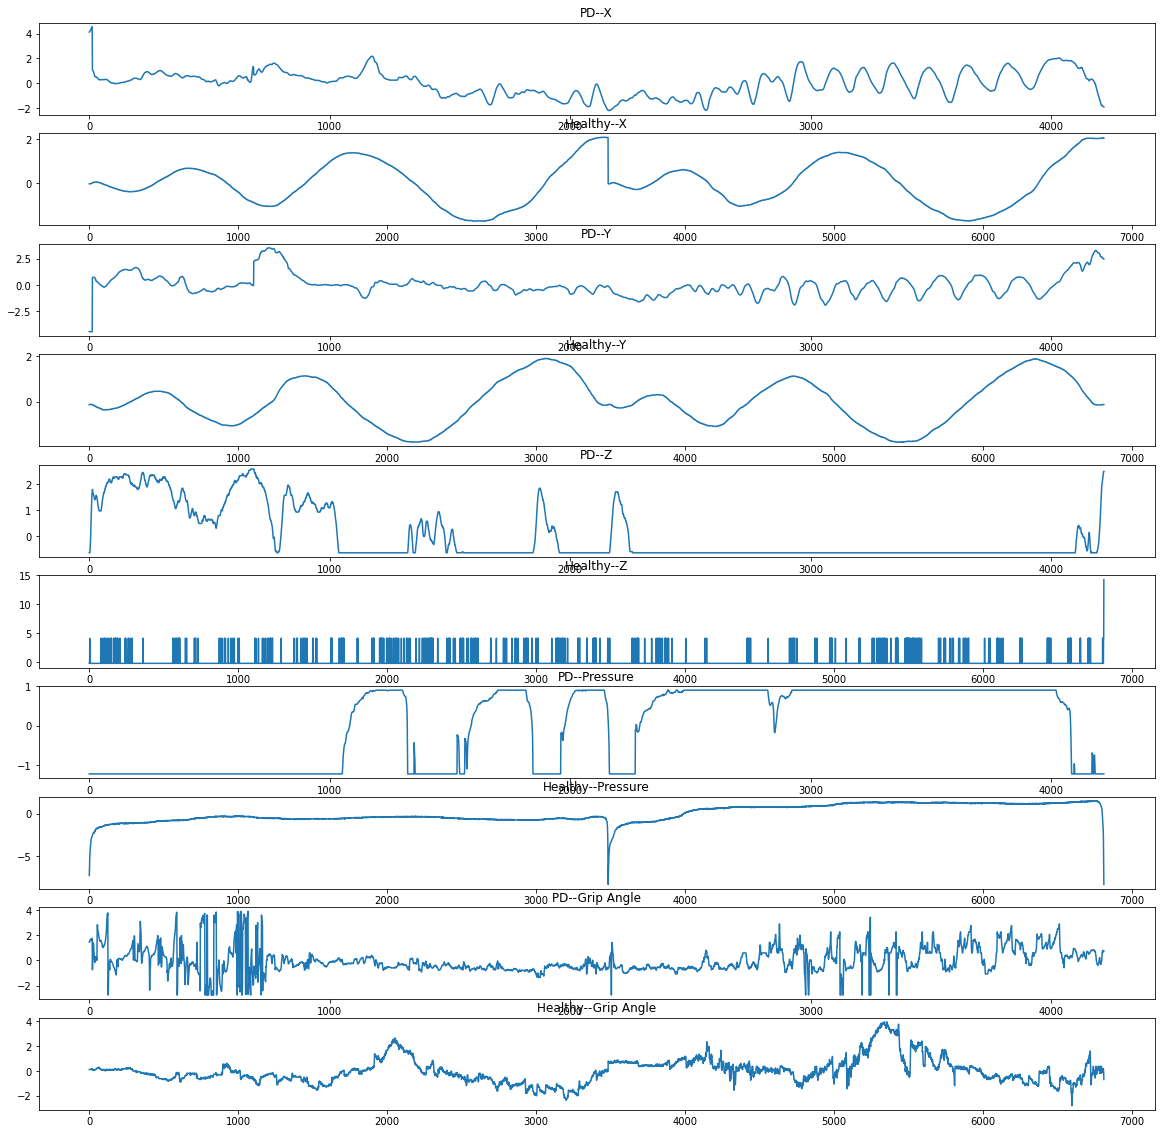

In [4]:
naming = ["--X", "--Y", "--Z", "--Pressure", "--Grip Angle"]
fig,axis =  plt.subplots(10,1,figsize=(20,20))

x_1 = np.arange(len(gen_points(pd)))
x_2 = np.arange(len(gen_points(healthy)))

for i in range(5):
    axis[2*i].plot(x_1,gen_points(pd)[:,i])
    axis[2*i].set_title('PD' + naming[i])
          
    axis[2*i+1].plot(x_2,gen_points(healthy)[:,i])
    axis[2*i+1].set_title('Healthy' + naming[i])
          
plt.show()

In [5]:
def get_spec(inp):
    specs = []
    
    for i in range(5):
        inp = tf.cast(inp, tf.float32)
        
        spectrogram = tf.signal.stft(
            inp[:,i], frame_length = 512, frame_step = 256)
    
        spectrogram = tf.math.log(tf.abs(spectrogram) + 1e-10)
        print(spectrogram.shape)
        specs.append(tf.expand_dims(spectrogram, axis = -1))
    
    return np.array(specs)

(15, 257)
(15, 257)
(15, 257)
(15, 257)
(15, 257)
(25, 257)
(25, 257)
(25, 257)
(25, 257)
(25, 257)


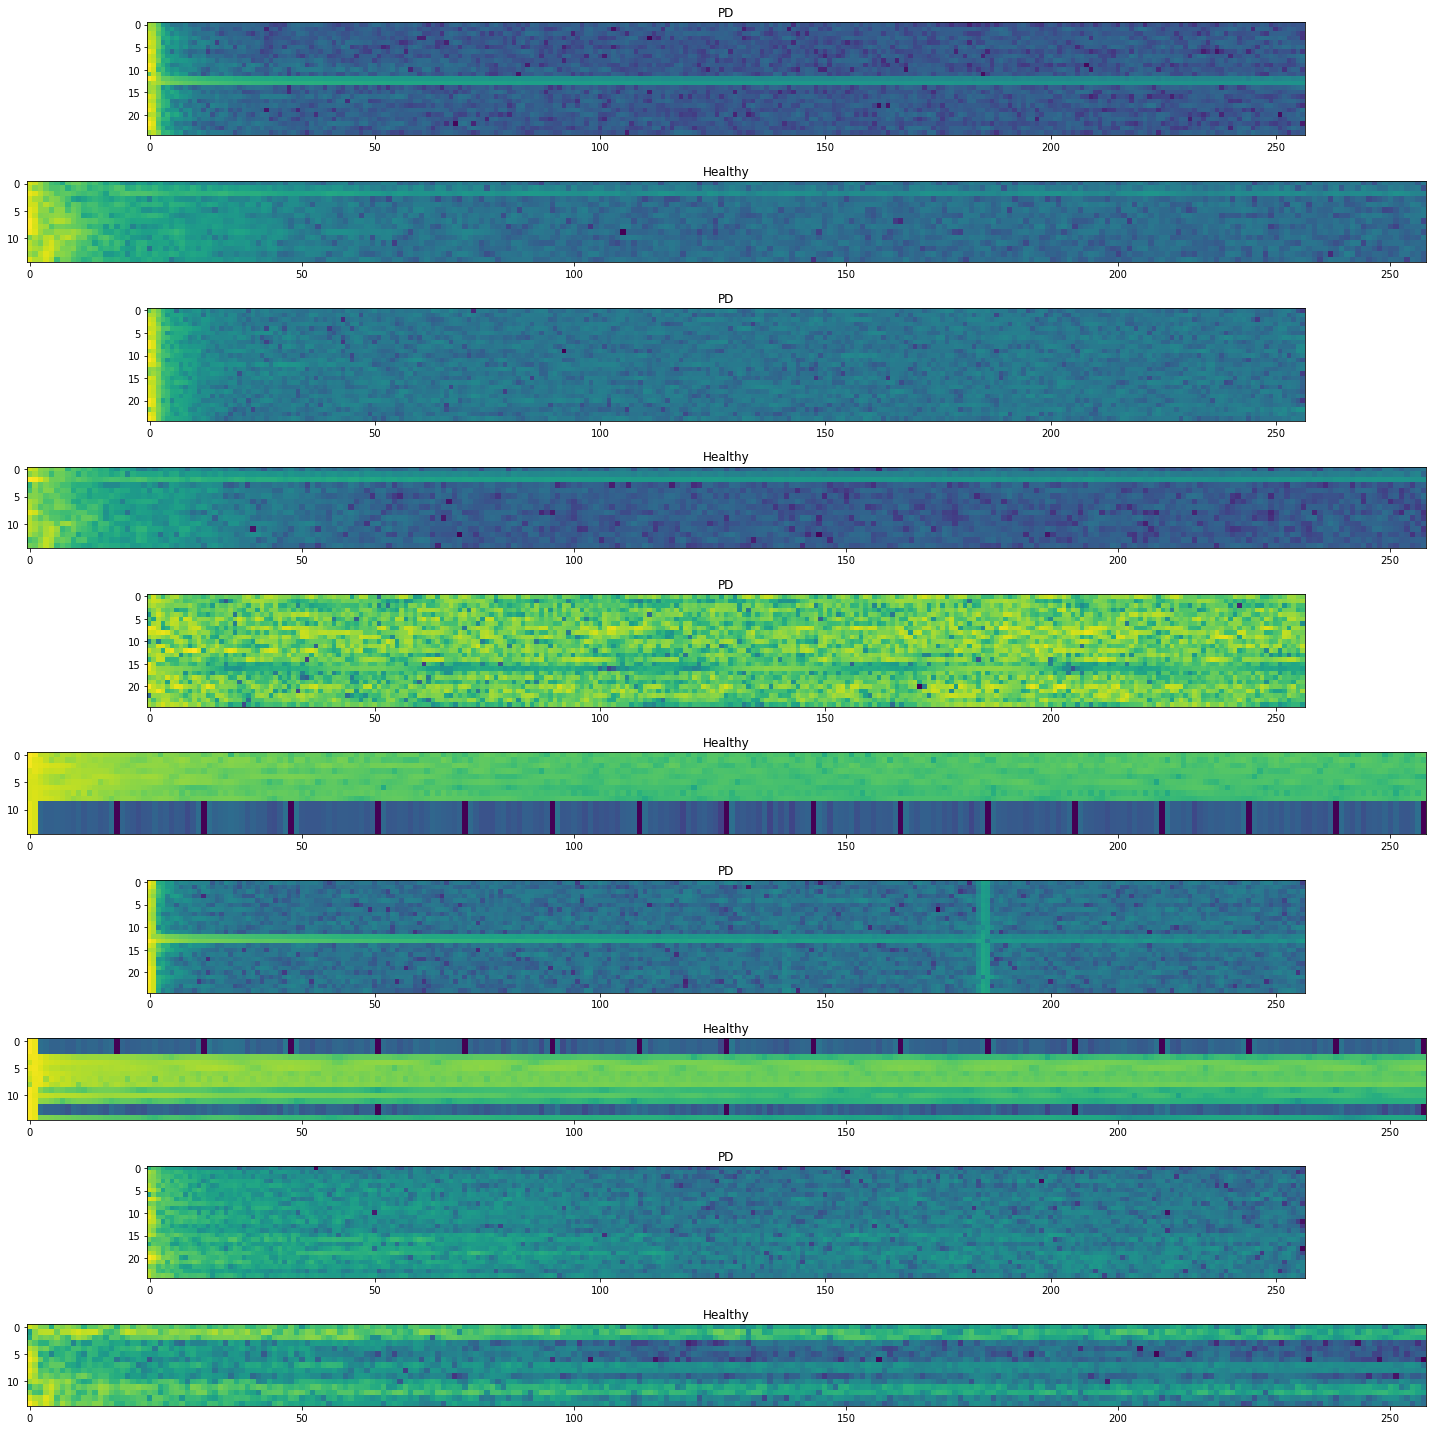

In [6]:
spectrogram = []
spectrogram.append(get_spec(gen_points(pd)))
spectrogram.append(get_spec(gen_points(healthy)))

figure, ax = plt.subplots(nrows = 10, ncols = 1, figsize=(20,20) )

for i in range(5):
    ax.ravel()[2*i].imshow(spectrogram[1][i,:,:,0])
    ax.ravel()[2*i].set_title("PD")
    ax.ravel()[2*i+1].imshow(spectrogram[0][i,:,:,0])
    ax.ravel()[2*i+1].set_title("Healthy")
    
plt.tight_layout()
plt.show()

In [24]:
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, data_folder, batch_size, IN_1, IN_2, shuffle = False):
        self.data_folder = data_folder
        self.batch_size = batch_size
        self.data_list = os.listdir(data_folder)
        self.IN_1 = IN_1
        self.IN_2 = IN_2
    
    def __len__(self):
        return int(np.floor(len(self.data_list)/self.batch_size))
    
    def __getitem__(self, idx):
    
        X, y = self.__data_generation(idx)
        return X,y
    
    def get_spec(self, inp):
        
        inp = tf.cast(inp, tf.float32)
        
        spectrogram = tf.signal.stft(
            inp, frame_length = 512, frame_step = 256)
        
        spectrogram = tf.abs(spectrogram)
        
        return np.resize(spectrogram, (self.IN_1,self.IN_2))
        
        
    def __data_generation(self, idx):
        
        X_1, X_2, X_3, X_4, X_5 = [],[],[],[],[]
        
        X = []
        y = []
        
        for j in range(idx*self.batch_size, (idx+1)*self.batch_size):
            
            data_list = []
            
            f = open(self.data_folder + self.data_list[idx], "r")
            
            for x in f:
                data_list.append([int(x) for x in x[:-1].split(';')])
            data_list = np.array(data_list, dtype = float)

            for i in range(5):
                data_list[:,i] = (data_list[:,i] - np.mean(data_list[:,i]))/np.std(data_list[:,i])

            X_1.append(self.get_spec(tf.constant(data_list)[:,0]))     
            X_2.append(self.get_spec(tf.constant(data_list)[:,1]))         
            X_3.append(self.get_spec(tf.constant(data_list)[:,2]))
            X_4.append(self.get_spec(tf.constant(data_list)[:,3]))
            X_5.append(self.get_spec(tf.constant(data_list)[:,4]))

            if(self.data_list[idx][0] == 'C'):
                y.append(0)
            else:
                y.append(1)
            X = [tf.convert_to_tensor(X_1), tf.convert_to_tensor(X_2),tf.convert_to_tensor(X_3),tf.convert_to_tensor(X_4),tf.convert_to_tensor(X_5)]

        return X, tf.convert_to_tensor(y)

In [25]:
train_images = 'D:/Machine_Learning/datasets/PARKINSON_HW/parkinson/train_data/'
val_images = 'D:/Machine_Learning/datasets/PARKINSON_HW/parkinson/val_data/'

IN_1, IN_2 = 32, 257
BATCH_SIZE = 2
EPOCH = 20

In [26]:
train_gen = DataGenerator(train_images, BATCH_SIZE, IN_1, IN_2)
val_gen = DataGenerator(val_images, BATCH_SIZE, IN_1, IN_2)

<h1>MODELING</H1>

In [20]:
class ConvLayer(tf.keras.Model):
    
    def __init__(self, NUM_FILTERS):
        super(ConvLayer, self).__init__()
        self.conv = Conv1D(NUM_FILTERS, 5, padding = 'same', activation = 'relu')
        
    def call(self, x):
        x = self.conv(x)
        
        return x

In [30]:
inputs = [tf.keras.Input(shape = (IN_1, IN_2)) for _ in range(5)]

x_out = []

for i in range(5):
    x = ConvLayer(4)(inputs[i])
    x = ConvLayer(8)(x)
    x = Flatten()(x)
    x_out.append(x)
x_out = tf.concat(x_out, axis = -1)

x_out = Dense(32)(x_out)
x_out = Dense(1, activation = 'sigmoid')(x_out)

model = tf.keras.Model(inputs = inputs, outputs = x_out)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 32, 257)]    0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 32, 257)]    0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 32, 257)]    0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 32, 257)]    0                                            
_______________________________________________________________________________________

<h1> TRAINING AND OPTIMIZATION </h1>

In [31]:
LR = 1e-3

model.compile(

    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = Adam(lr = LR),
    metrics = [BinaryAccuracy(), Precision(), Recall(), TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()]
)

In [32]:
checkpoint_filepath = 'parkinson/cnn_dense.hdf5'

callback = tf.keras.callbacks.ModelCheckpoint(

    filepath = checkpoint_filepath,
    save_weights_only = True,
    monitor = 'val_binary_accuracy',
    mode = 'max',
    save_best_only = True)

#Train model on dataset
history = model.fit(train_gen, validation_data = val_gen, shuffle = True, epochs = EPOCH, callbacks = [callback])

Epoch 1/20
 5/31 [===>..........................] - ETA: 3s - loss: 11.0671 - binary_accuracy: 0.4000 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - true_positives_2: 0.0000e+00 - true_negatives_2: 4.0000 - false_positives_2: 4.0000 - false_negatives_2: 2.0000      

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


31/31 [==============================] - 7s 225ms/step - loss: 4.2109 - binary_accuracy: 0.7097 - precision_2: 0.7619 - recall_2: 0.8000 - true_positives_2: 32.0000 - true_negatives_2: 12.0000 - false_positives_2: 10.0000 - false_negatives_2: 8.0000 - val_loss: 5.1273 - val_binary_accuracy: 0.1429 - val_precision_2: 0.2000 - val_recall_2: 0.3333 - val_true_positives_2: 2.0000 - val_true_negatives_2: 0.0000e+00 - val_false_positives_2: 8.0000 - val_false_negatives_2: 4.0000
Epoch 2/20
31/31 [==============================] - 6s 190ms/step - loss: 0.3740 - binary_accuracy: 0.9355 - precision_2: 1.0000 - recall_2: 0.9000 - true_positives_2: 36.0000 - true_negatives_2: 22.0000 - false_positives_2: 0.0000e+00 - false_negatives_2: 4.0000 - val_loss: 6.0340 - val_binary_accuracy: 0.1429 - val_precision_2: 0.2000 - val_recall_2: 0.3333 - val_true_positives_2: 2.0000 - val_true_negatives_2: 0.0000e+00 - val_false_positives_2: 8.0000 - val_false_negatives_2: 4.0000
Epoch 3/20
31/31 [============

31/31 [==============================] - 6s 191ms/step - loss: 2.1406e-05 - binary_accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000 - true_positives_2: 40.0000 - true_negatives_2: 22.0000 - false_positives_2: 0.0000e+00 - false_negatives_2: 0.0000e+00 - val_loss: 5.4877 - val_binary_accuracy: 0.5714 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_true_positives_2: 0.0000e+00 - val_true_negatives_2: 8.0000 - val_false_positives_2: 0.0000e+00 - val_false_negatives_2: 6.0000
Epoch 18/20
31/31 [==============================] - 6s 202ms/step - loss: 1.9785e-05 - binary_accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000 - true_positives_2: 40.0000 - true_negatives_2: 22.0000 - false_positives_2: 0.0000e+00 - false_negatives_2: 0.0000e+00 - val_loss: 5.4904 - val_binary_accuracy: 0.5714 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_true_positives_2: 0.0000e+00 - val_true_negatives_2: 8.0000 - val_false_positives_2: 0.0000e+00 - val_false_negati

In [41]:
plt.plot(history.history['loss'][0:60])
plt.plot(history.history['val_loss'][0:60])

plt.title('model loss')
plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

In [42]:
plt.plot(history.history['binary_accuracy'][0:60])
plt.plot(history.history['val_binary_accuracy'][0:60])

plt.title('model accuracy')
plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

In [40]:
out = model.evaluate(val_gen)

print(out)

val_tp = out[-4]
val_tn = out[-3]
val_fp = out[-2]
val_fn = out[-1]

print("|-------------------------------------------------------------------------------|")
print("|        Val TN : {}      ------      Val FP : {}     --------|".format(val_tn, val_fp))
print("|-------------------------------------------------------------------------------|")
print("|        Val FN : {}      ------      Val TP : {}     --------|".format(val_fn, val_tp))
print("|-------------------------------------------------------------------------------|")

In [ ]:
def get_spec(inp):
    specs = []
    
    for i in range(5):
        inp = tf.cast(inp, tf.float32)
        
        spectrogram = tf.signal.stft(
            inp[:,i], frame_length = 512, frame_step = 256)
    
        spectrogram = tf.math.log(tf.abs(spectrogram) + 1e-10)
        specs.append(tf.expand_dims(spectrogram, axis = -1))
    
    return np.resize(spectrogram, (IN_1, IN_2))

In [ ]:
model.load_weights(checkpoint_filepath)

def detect(test_image):\n",
    
    X = []
    data_list = []
    
    f = open(test_image, "r")
    for x in f:
        data_list.append([int(x) for x in x[:-1].split(';')])
    
    data_list = np.array(data_list, dtype = float)
    
    for i in range(5):
        data_list[:,i] = (data_list[:,i] - np.mean(data_list[:,i]))/np.std(data_list[:,i])
    
    for i in range(5):
        X.append(tf.expand_dims(get_spec(tf.constant(data_list)), axis = 0))
    
    return model.predict(X)
    
test_images = 'D:/Machine_Learning/datasets/PARKINSON_HW/parkinson/val_data/H_P000-0004.txt'
print(detect(test_images))
print( "This Person is : PD" if detect(test_images)[0][0]> 0.5 else "This Person is : Healthy")